# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [17]:
from pyberries.data import DatasetPool
import seaborn.objects as so

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['240424_1', '240424_2', '240424_3', '240424_4'],
                    groups=['WT, 0', 'WT, 30 ng/mL', 'ΔrecA, 0', 'ΔrecA, 30 ng/mL'],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name=['Nucleoid', 'RecB_spots'])
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 240424_1 (group WT, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2 (group WT, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_3 (group ΔrecA, 0): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_4 (group ΔrecA, 30 ng/mL): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']


In [18]:
data.describe(object_name='Bacteria_large')

Bacteria_large


,Group,nObjects,RecBIntensity,Area,SNR,RecBSpotCount,SpineWidth,SpineLength,NextDivisionFrame,PreviousDivisionFrame,NucleoidCount,Time_min,Time_min_bin
Dataset,,,,,,,,,,,,,
240424_1,"WT, 0",49600,3599.316919,3.014601,429.832473,0.030060,0.842242,3.114085,NaN,NaN,1.426411,37.283867,29.667339
240424_2,"WT, 30 ng/mL",80000,3608.020641,3.251460,583.069648,0.040675,0.829891,3.411693,NaN,NaN,1.183750,38.159507,31.734375
240424_3,"ΔrecA, 0",32750,3325.824053,2.961768,305.981113,0.048519,0.850367,3.057346,NaN,NaN,1.329771,40.949827,33.755725
240424_4,"ΔrecA, 30 ng/mL",42150,3488.600857,3.085181,354.494473,0.078766,0.867253,3.140447,NaN,NaN,1.474496,47.332807,40.391459


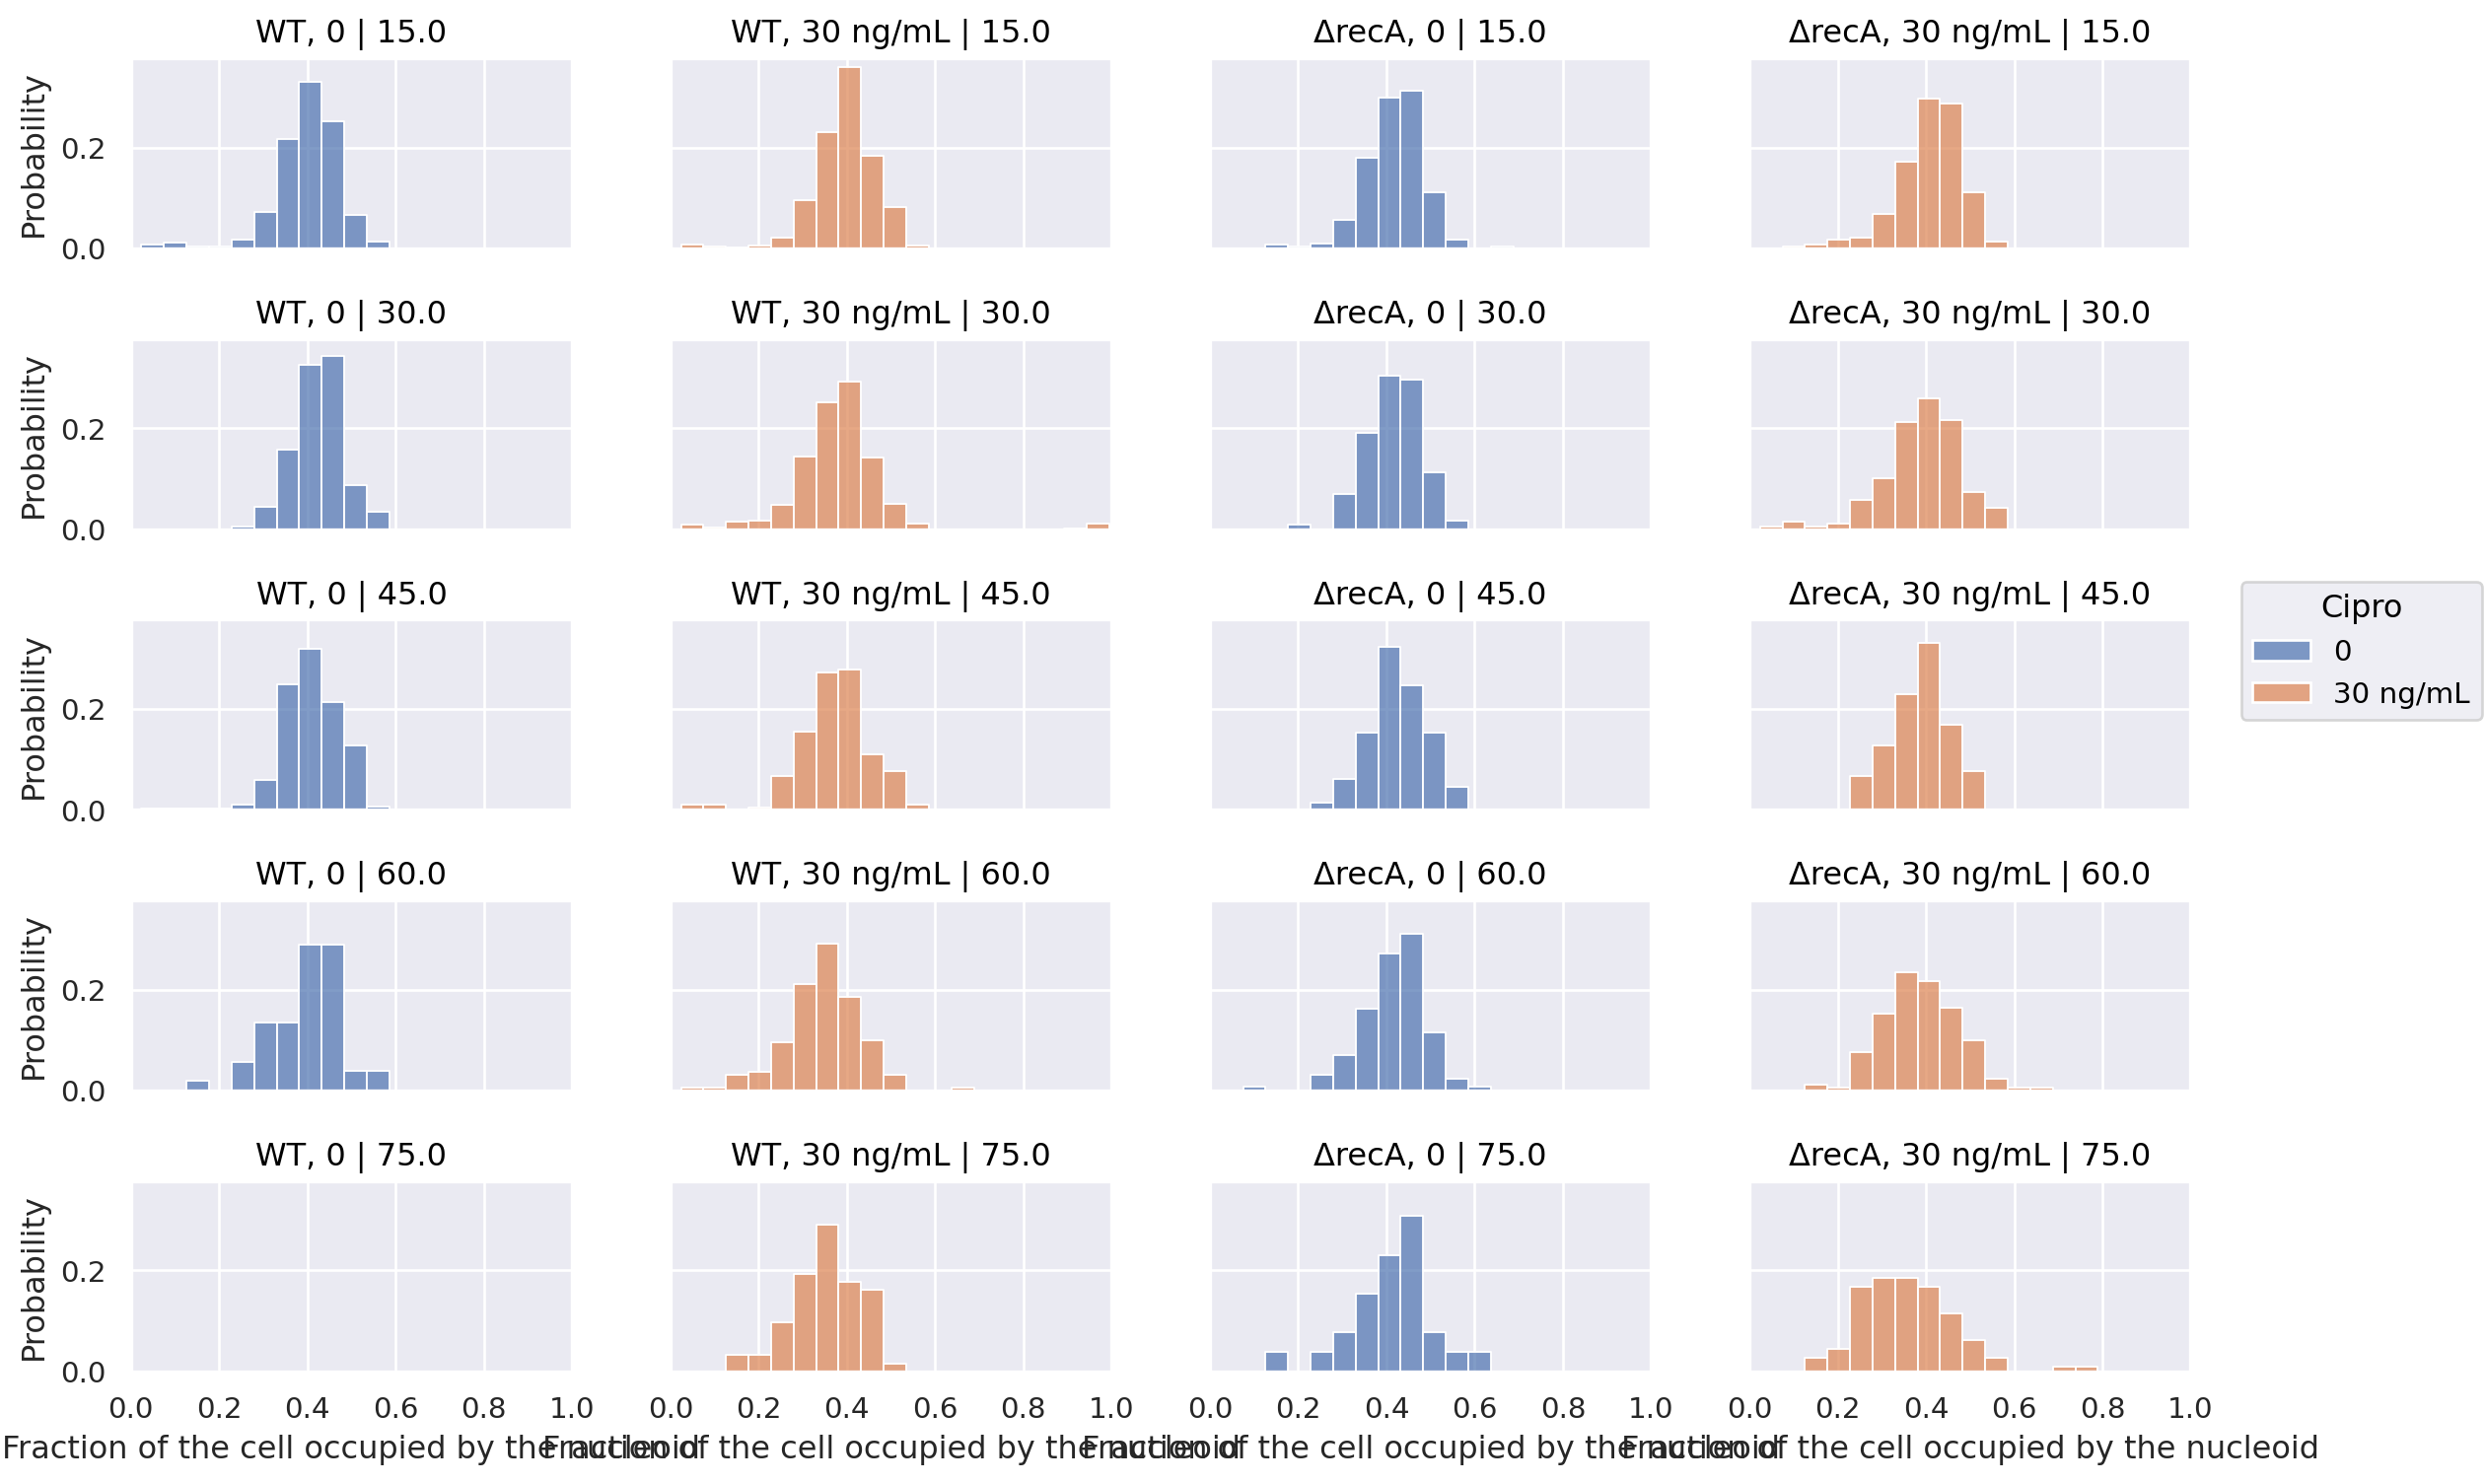

In [5]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      )

(
    so.Plot(df, x='frac_nucleoid', color='Cipro')
    .layout(size=(12, 8))
    .facet(row='Time_min_bin', col='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.05, common_norm=False))
    .limit(x=(0, 1))
    .label(x='Fraction of the cell occupied by the nucleoid', y='Probability')
)

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

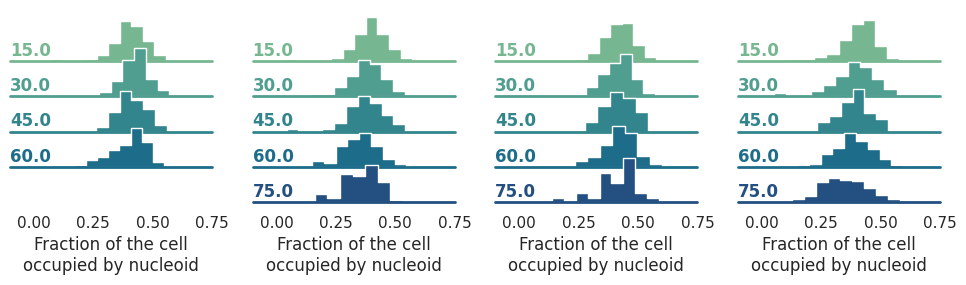

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='Nucleoid_size', agg='sum')
      .Bacteria_large
      .assign(frac_nucleoid=lambda df: df.Nucleoid_size / df.Area)
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Time_min_bin", aspect=6, height=.5, palette='crest')
g.map(sns.histplot, 'frac_nucleoid', binwidth=0.05, common_norm=False, stat='probability', alpha=1, element='step', edgecolor='w')

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "frac_nucleoid")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.3)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Fraction of the cell\noccupied by nucleoid', xlim=(-0.1,0.75))
g.despine(bottom=True, left=True)

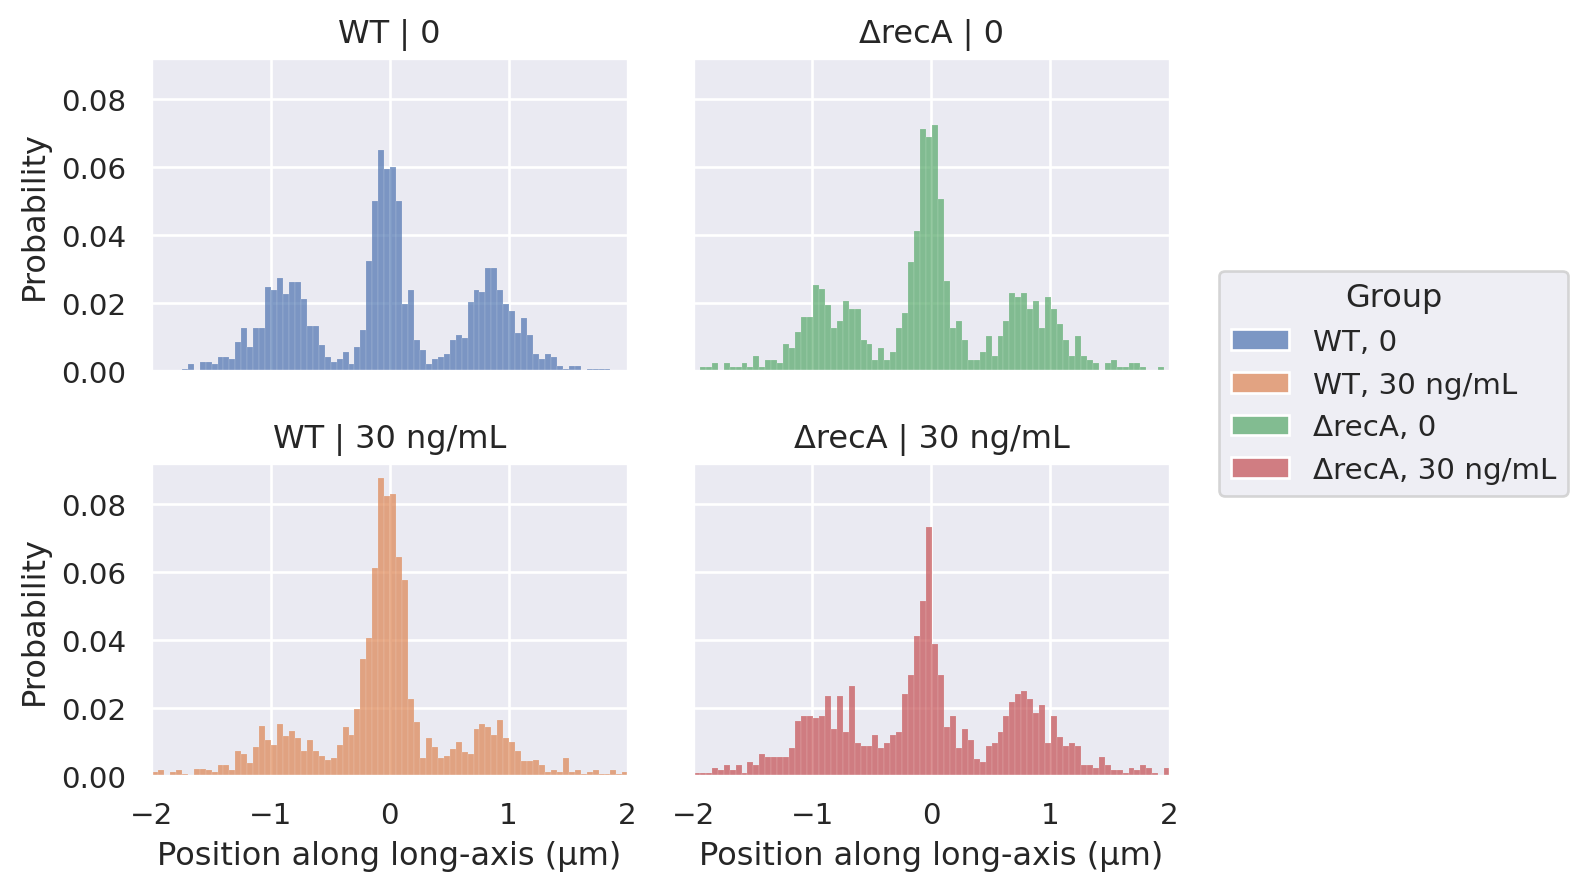

In [35]:
(
    so.Plot(data.Nucleoid, x='centerLongCoord', color='Group')
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.05, common_norm=False))
    .label(x='Position along long-axis (µm)', y='Probability')
    .limit(x=(-2, 2))
)

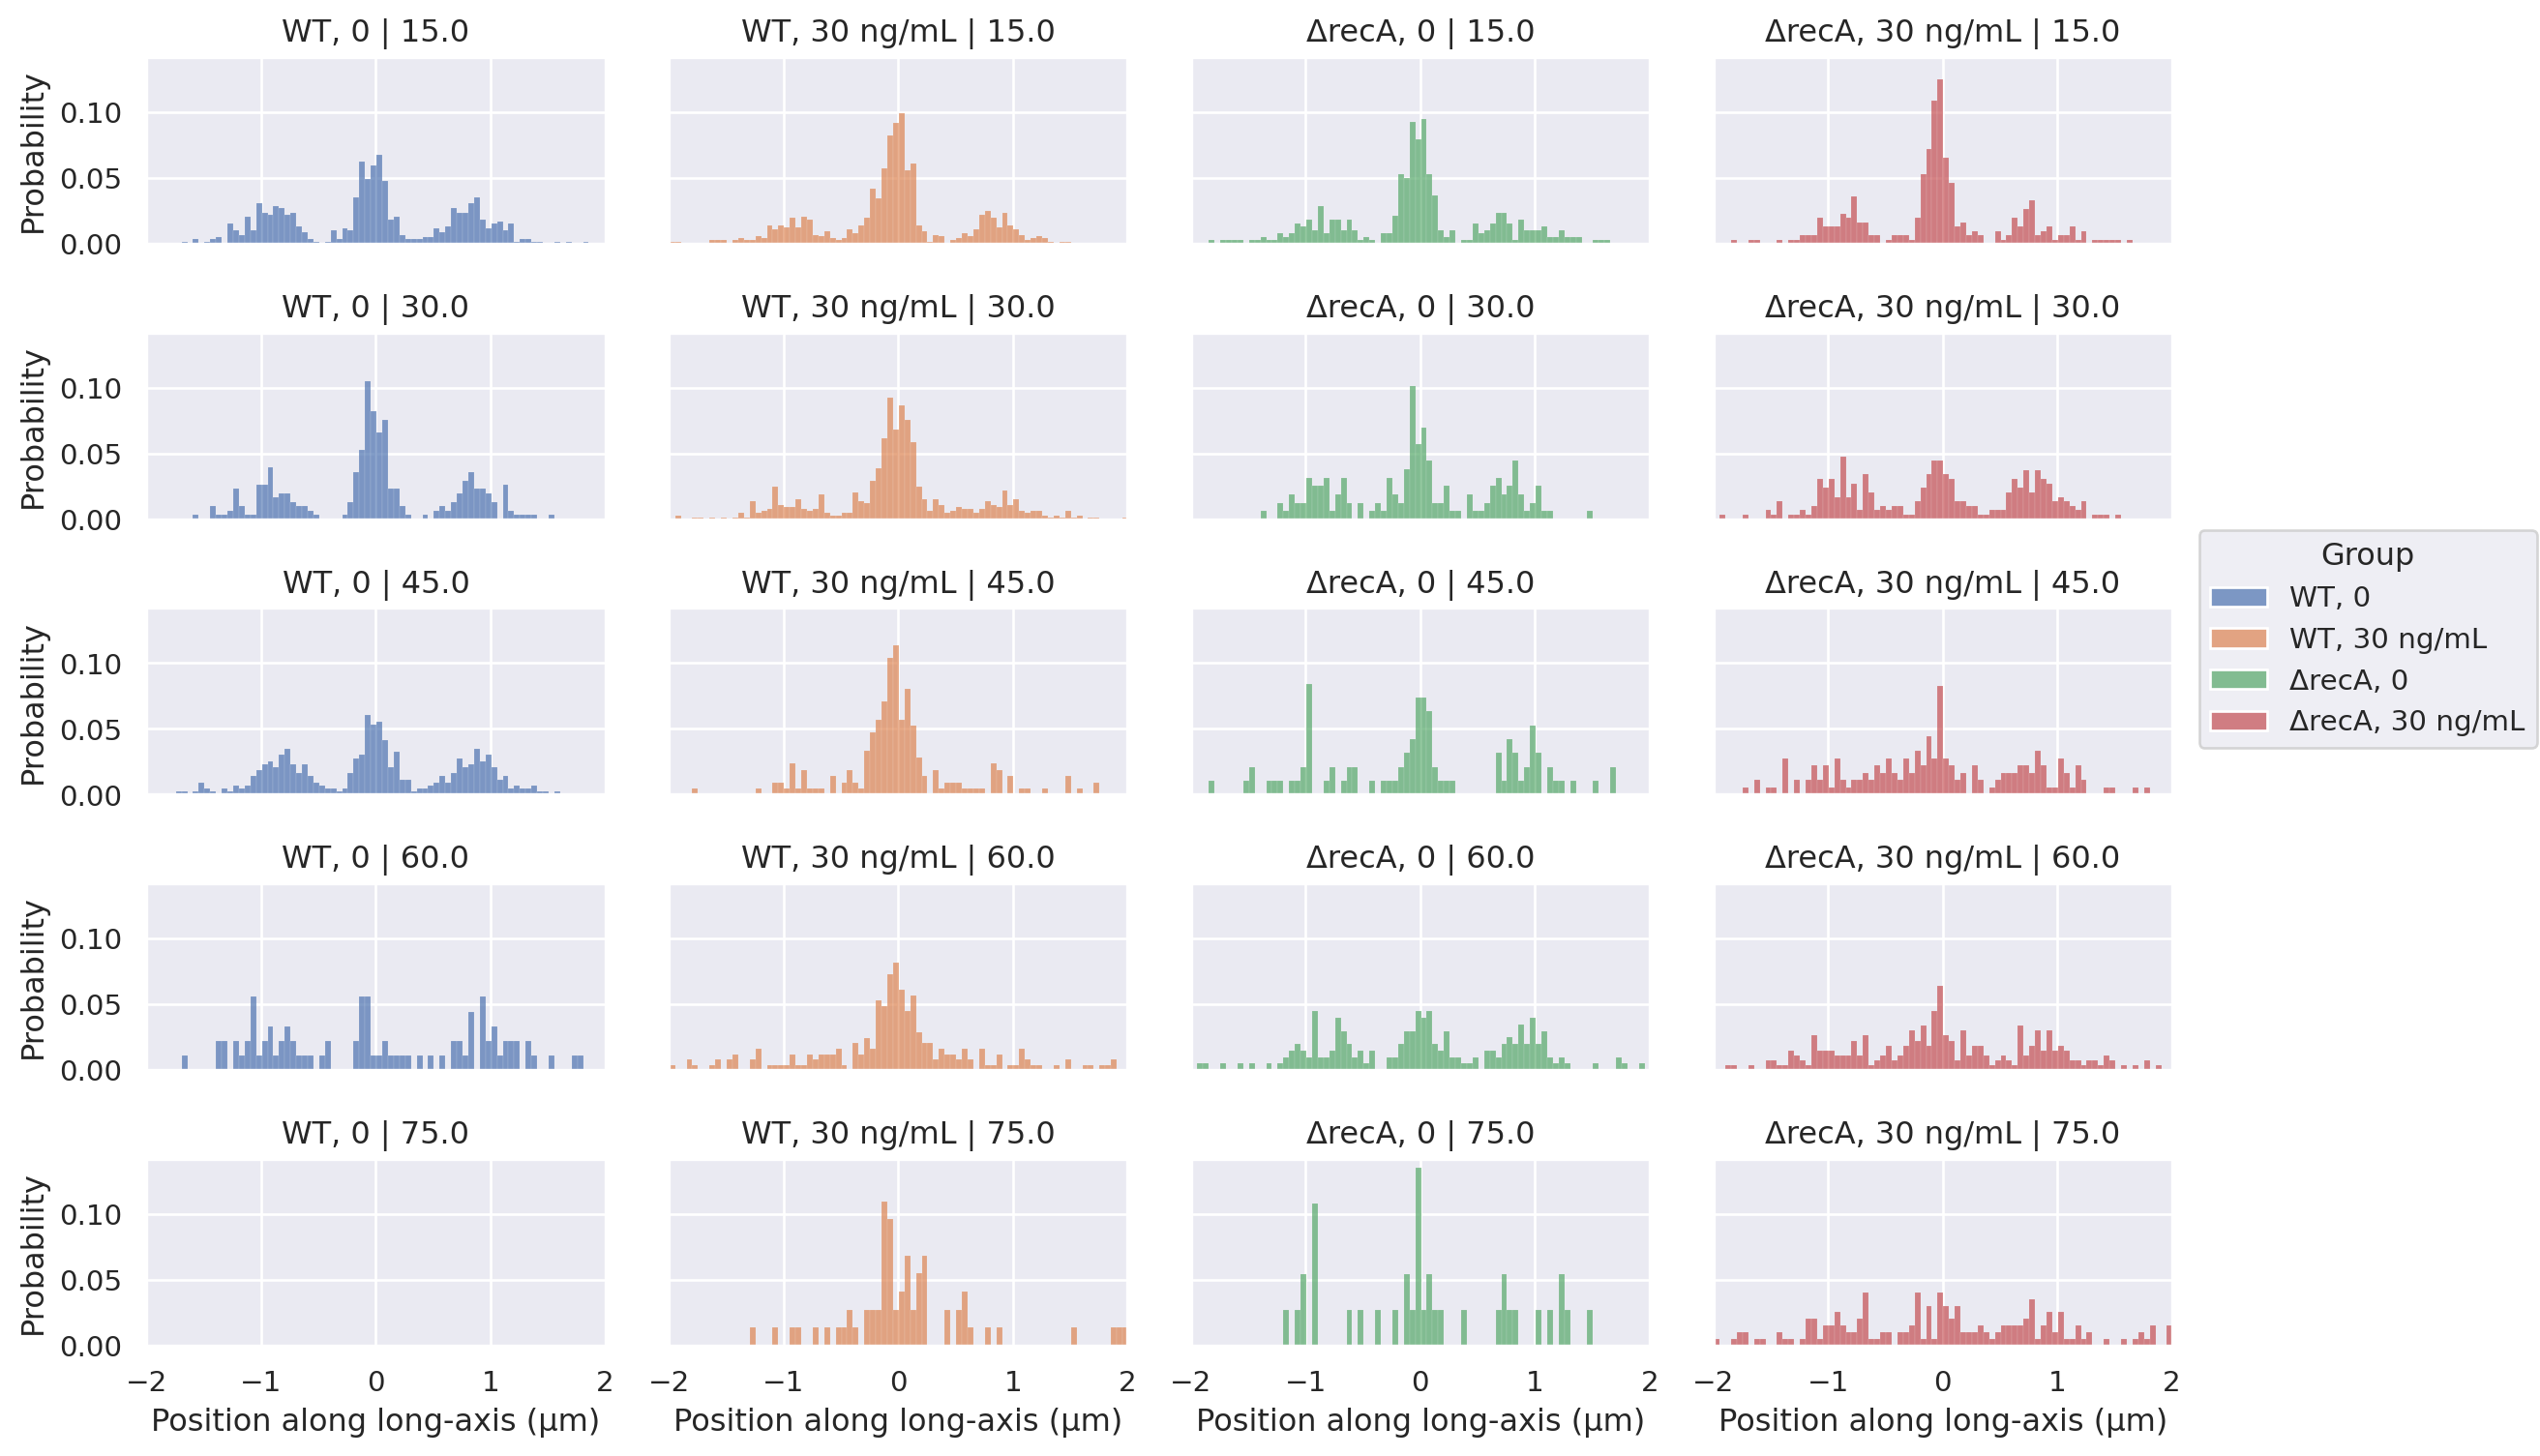

In [39]:
df = data.Nucleoid

(
    so.Plot(df, x='centerLongCoord', color='Group')
    .layout(size=(12, 8))
    .facet(row='Time_min_bin', col='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.05, common_norm=False))
    .limit(x=(-2, 2))
    .label(x='Position along long-axis (µm)', y='Probability')
)

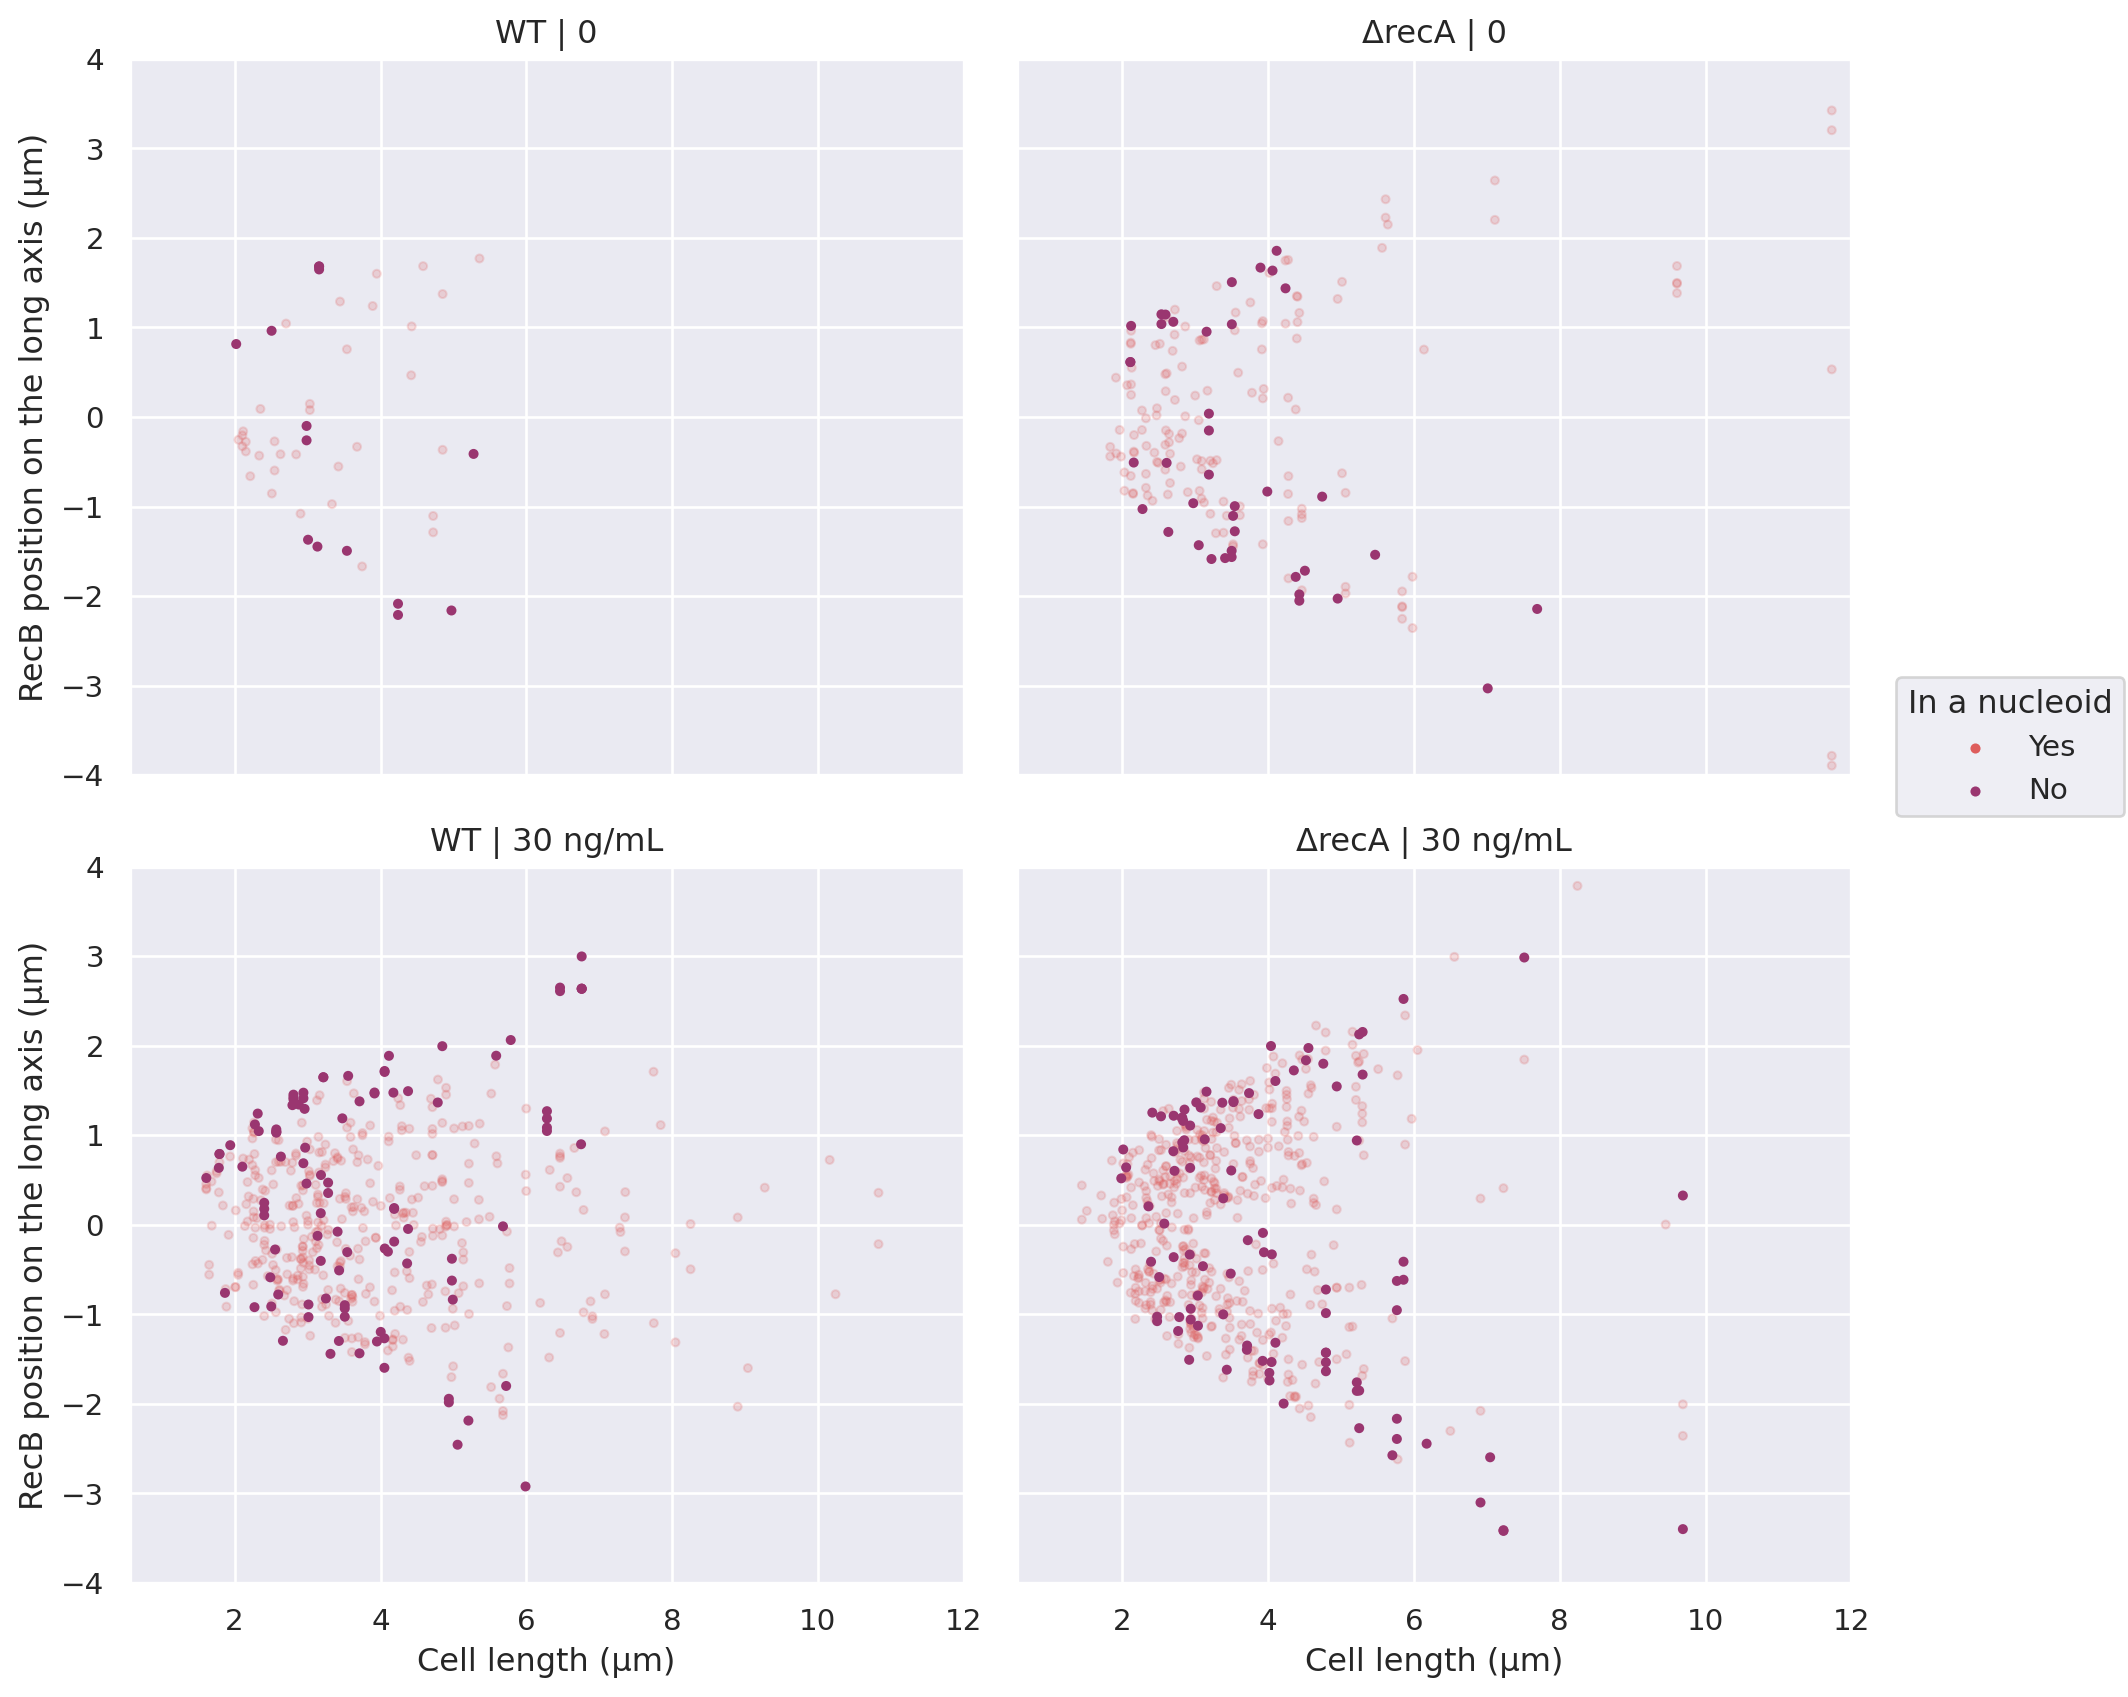

In [63]:
df = (data
      .apply_filters({'RecB_spots':'TrackLength >= 5'})
      .assign(object_name='RecB_spots', spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'))
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['centerLongCoord', 'spot_in_nucleoid'], child='RecB_spots', agg='first', rename=['RecB_pos', 'in_nucleoid'])
      .Bacteria_large
      .assign(in_nucleoid=lambda df: df.in_nucleoid.replace({0:'No', 1:'Yes'}))
      )

(
    so.Plot(df, x='SpineLength', y='RecB_pos', color='in_nucleoid')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.2, fillalpha=.2, pointsize=6), data=df.query('in_nucleoid == "Yes"'))
    .add(so.Dots(marker='.', alpha=1, fillalpha=1, pointsize=6), data=df.query('in_nucleoid == "No"'))
    .limit(x=(None, 12), y=(-4, 4))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='RecB position on the long axis (µm)', color='In a nucleoid')
)

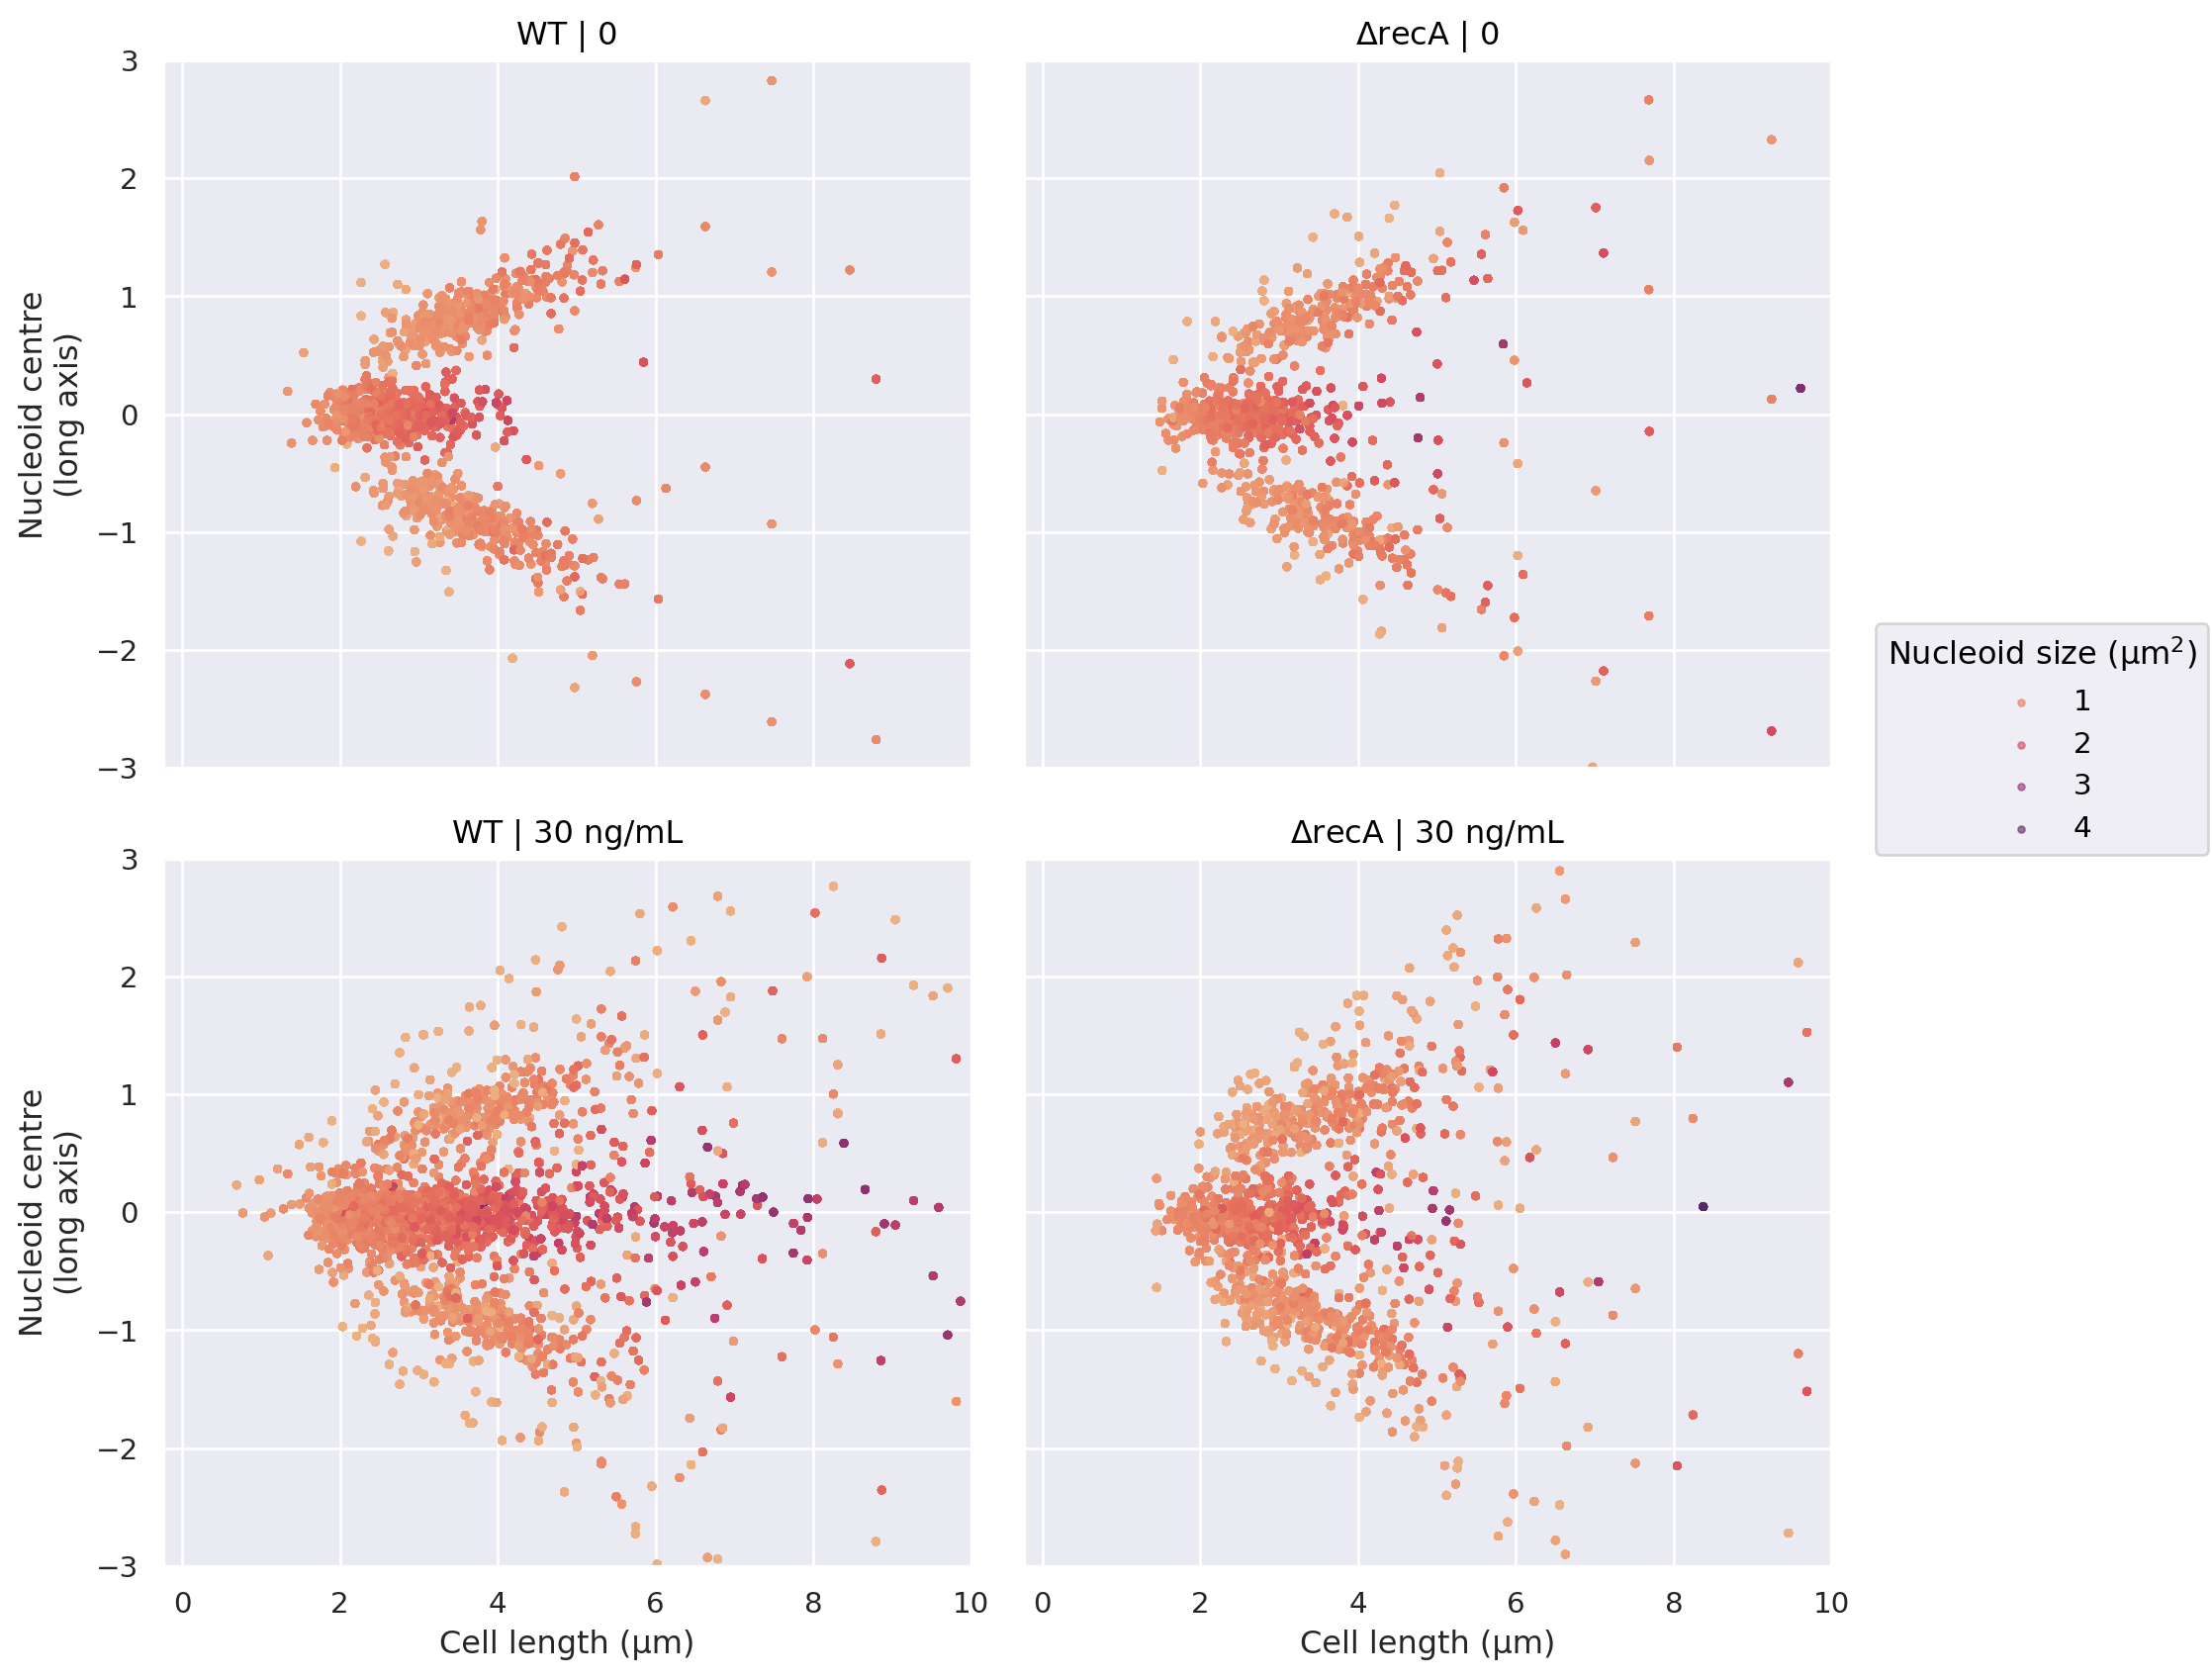

In [18]:
df = (data
      .Nucleoid
      )

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='Nucleoid_size')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=5))
    .limit(x=(None, 10), y=(-3, 3))
    .scale(color='flare')
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Nucleoid size (µm$^2$)')
)

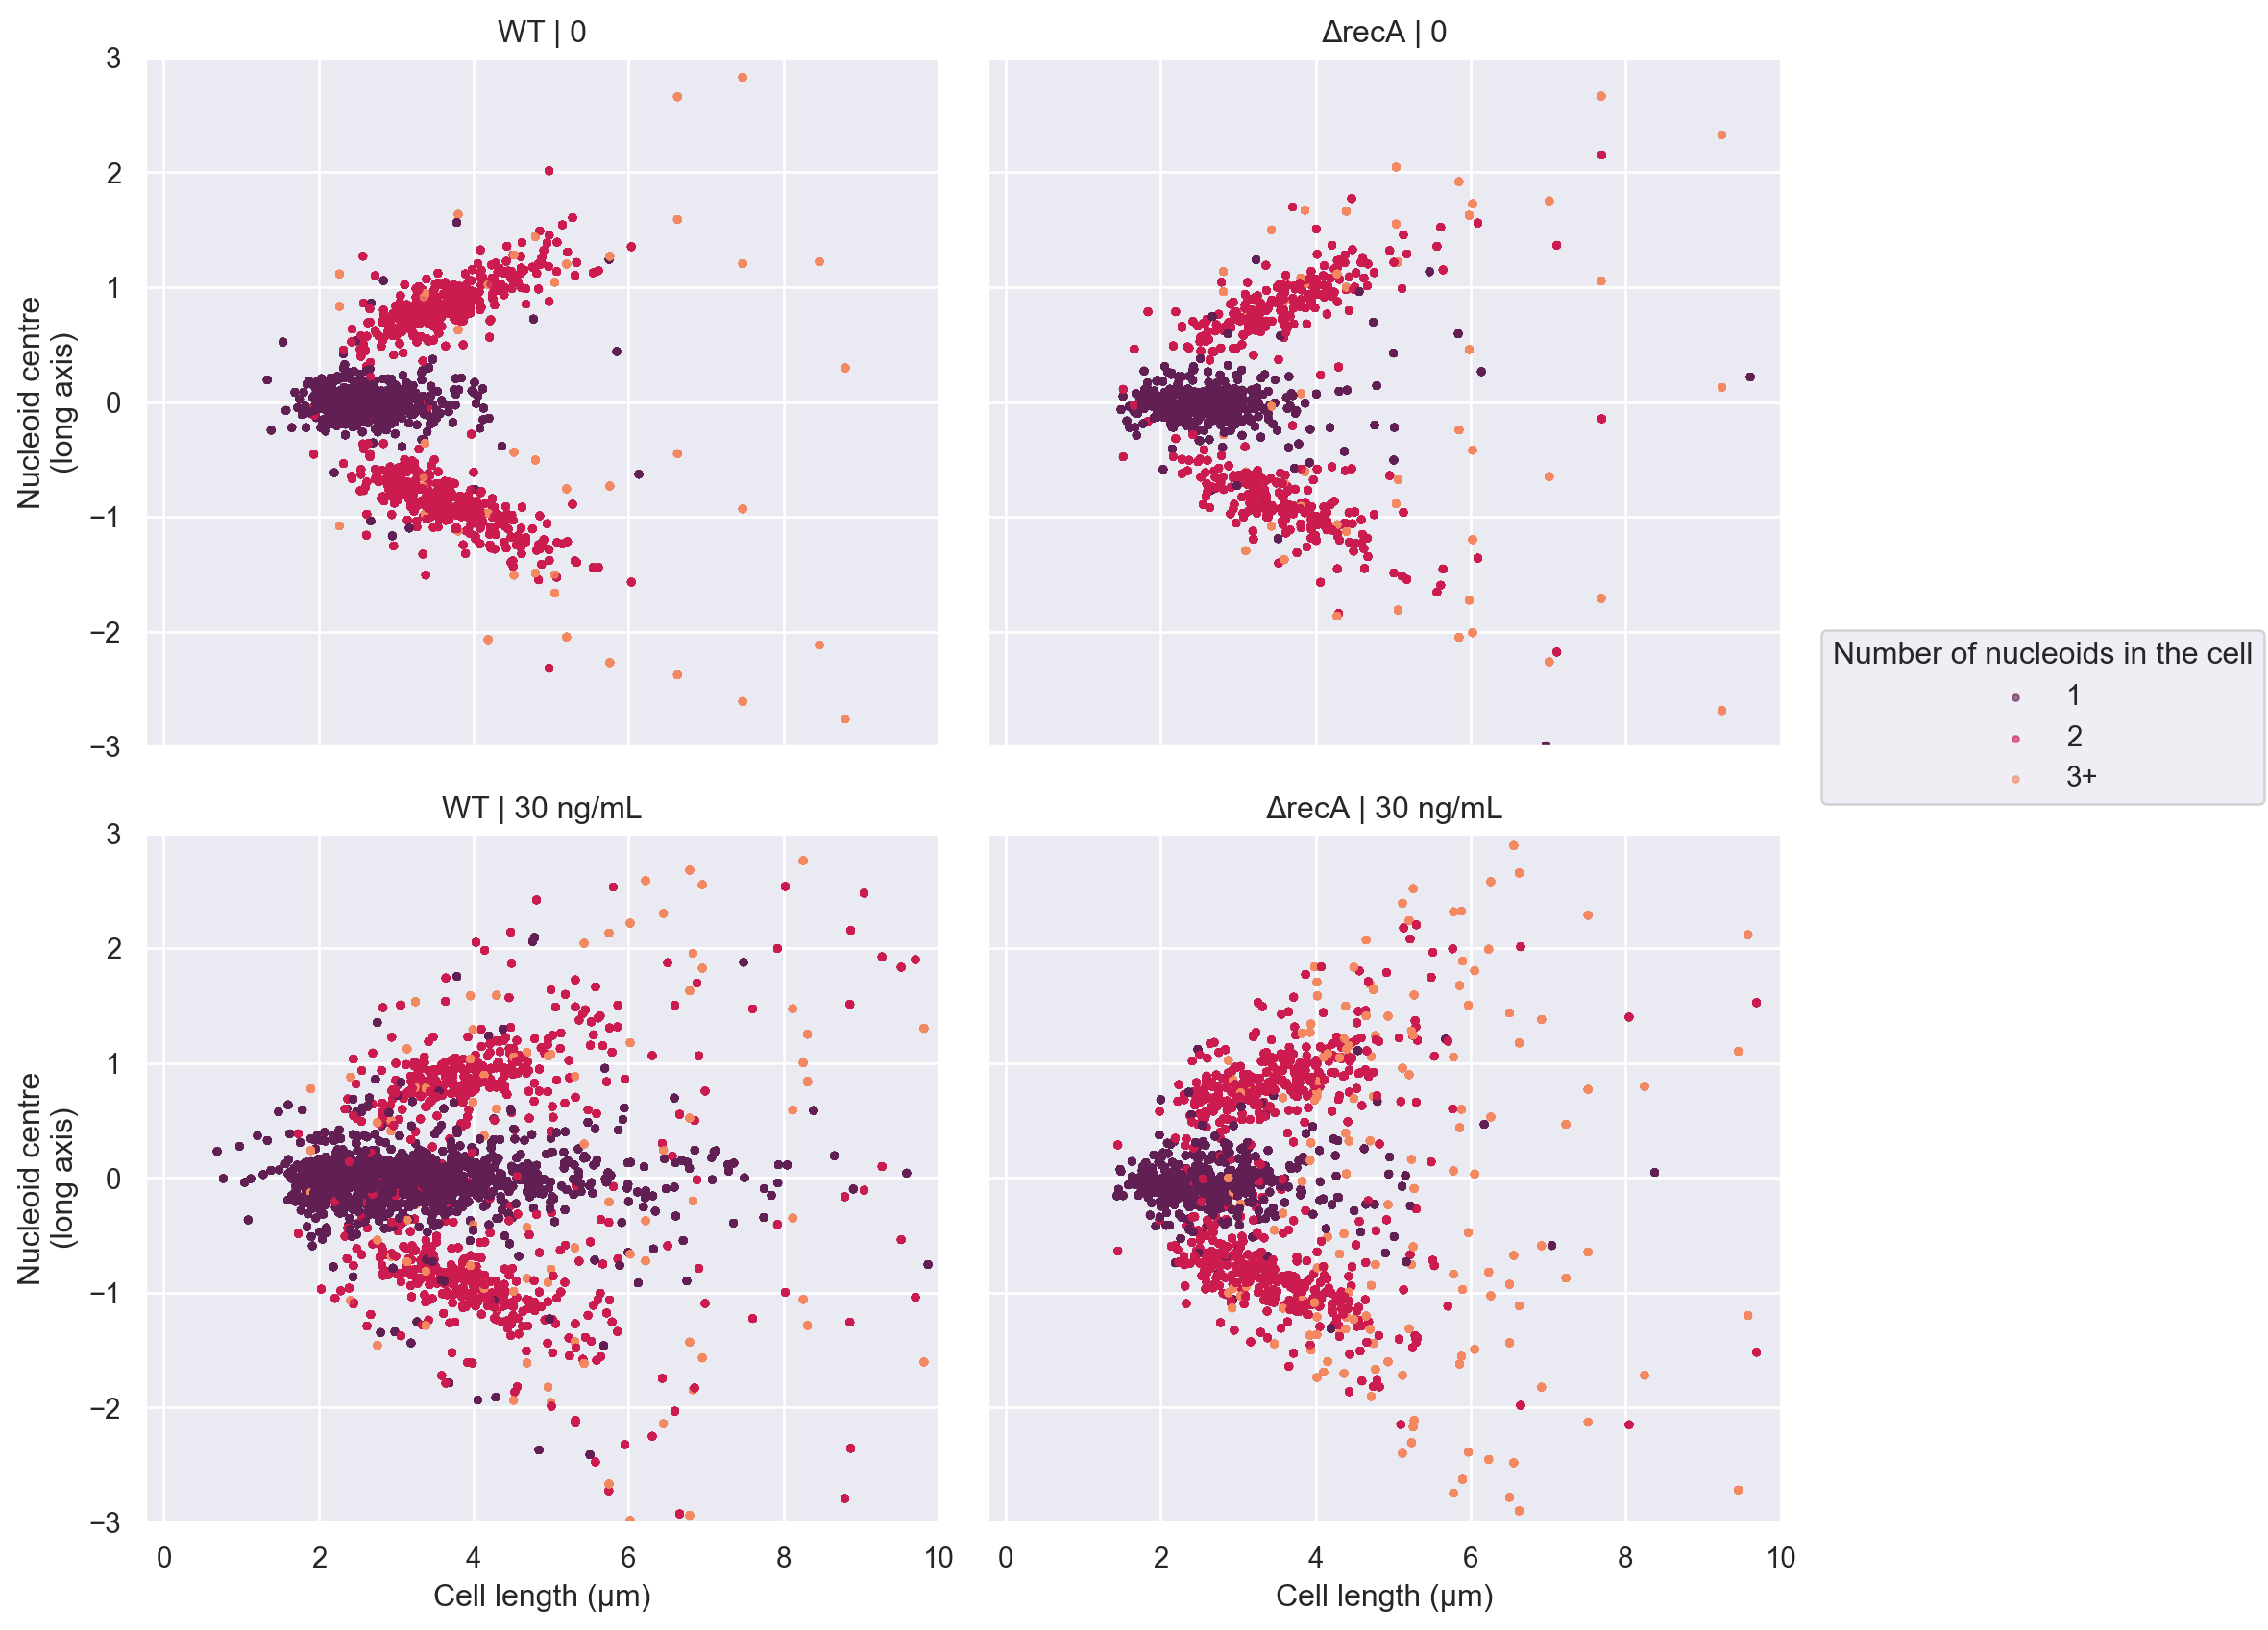

In [196]:
df = (data
      .add_from_parent(object_name='Nucleoid', col='NucleoidCount')
      .Nucleoid
      .assign(NucleoidCount=lambda df: df.NucleoidCount.astype('str').replace({'3':'3+', '4':'3+', '5':'3+'}))
      )

(
    so.Plot(df, x='SpineLength', y='centerLongCoord', color='NucleoidCount')
    .layout(size=(10,9))
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.', alpha=.6, fillalpha=.6, pointsize=5))
    .limit(x=(None, 10), y=(-3, 3))
    .scale(color=so.Nominal('rocket', order=['1', '2', '3+']))
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)', color='Number of nucleoids in the cell')
)

In [129]:
df = (data
      .get_parent_indices(object_name='RecB_spots')
      .RecB_spots
      .assign(spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.notna().astype('int'),
              long_spot=lambda df: df.TrackLength.ge(5)
              )
      .query('long_spot == True')
      .groupby('Group')
      .agg({'spot_in_nucleoid':'mean'})
      )

display(df)

,spot_in_nucleoid
Group,
"$\Delta$recA, 0",0.751269
"$\Delta$recA, 30 ng/mL",0.829187
"WT, 0",0.674419
"WT, 30 ng/mL",0.799197


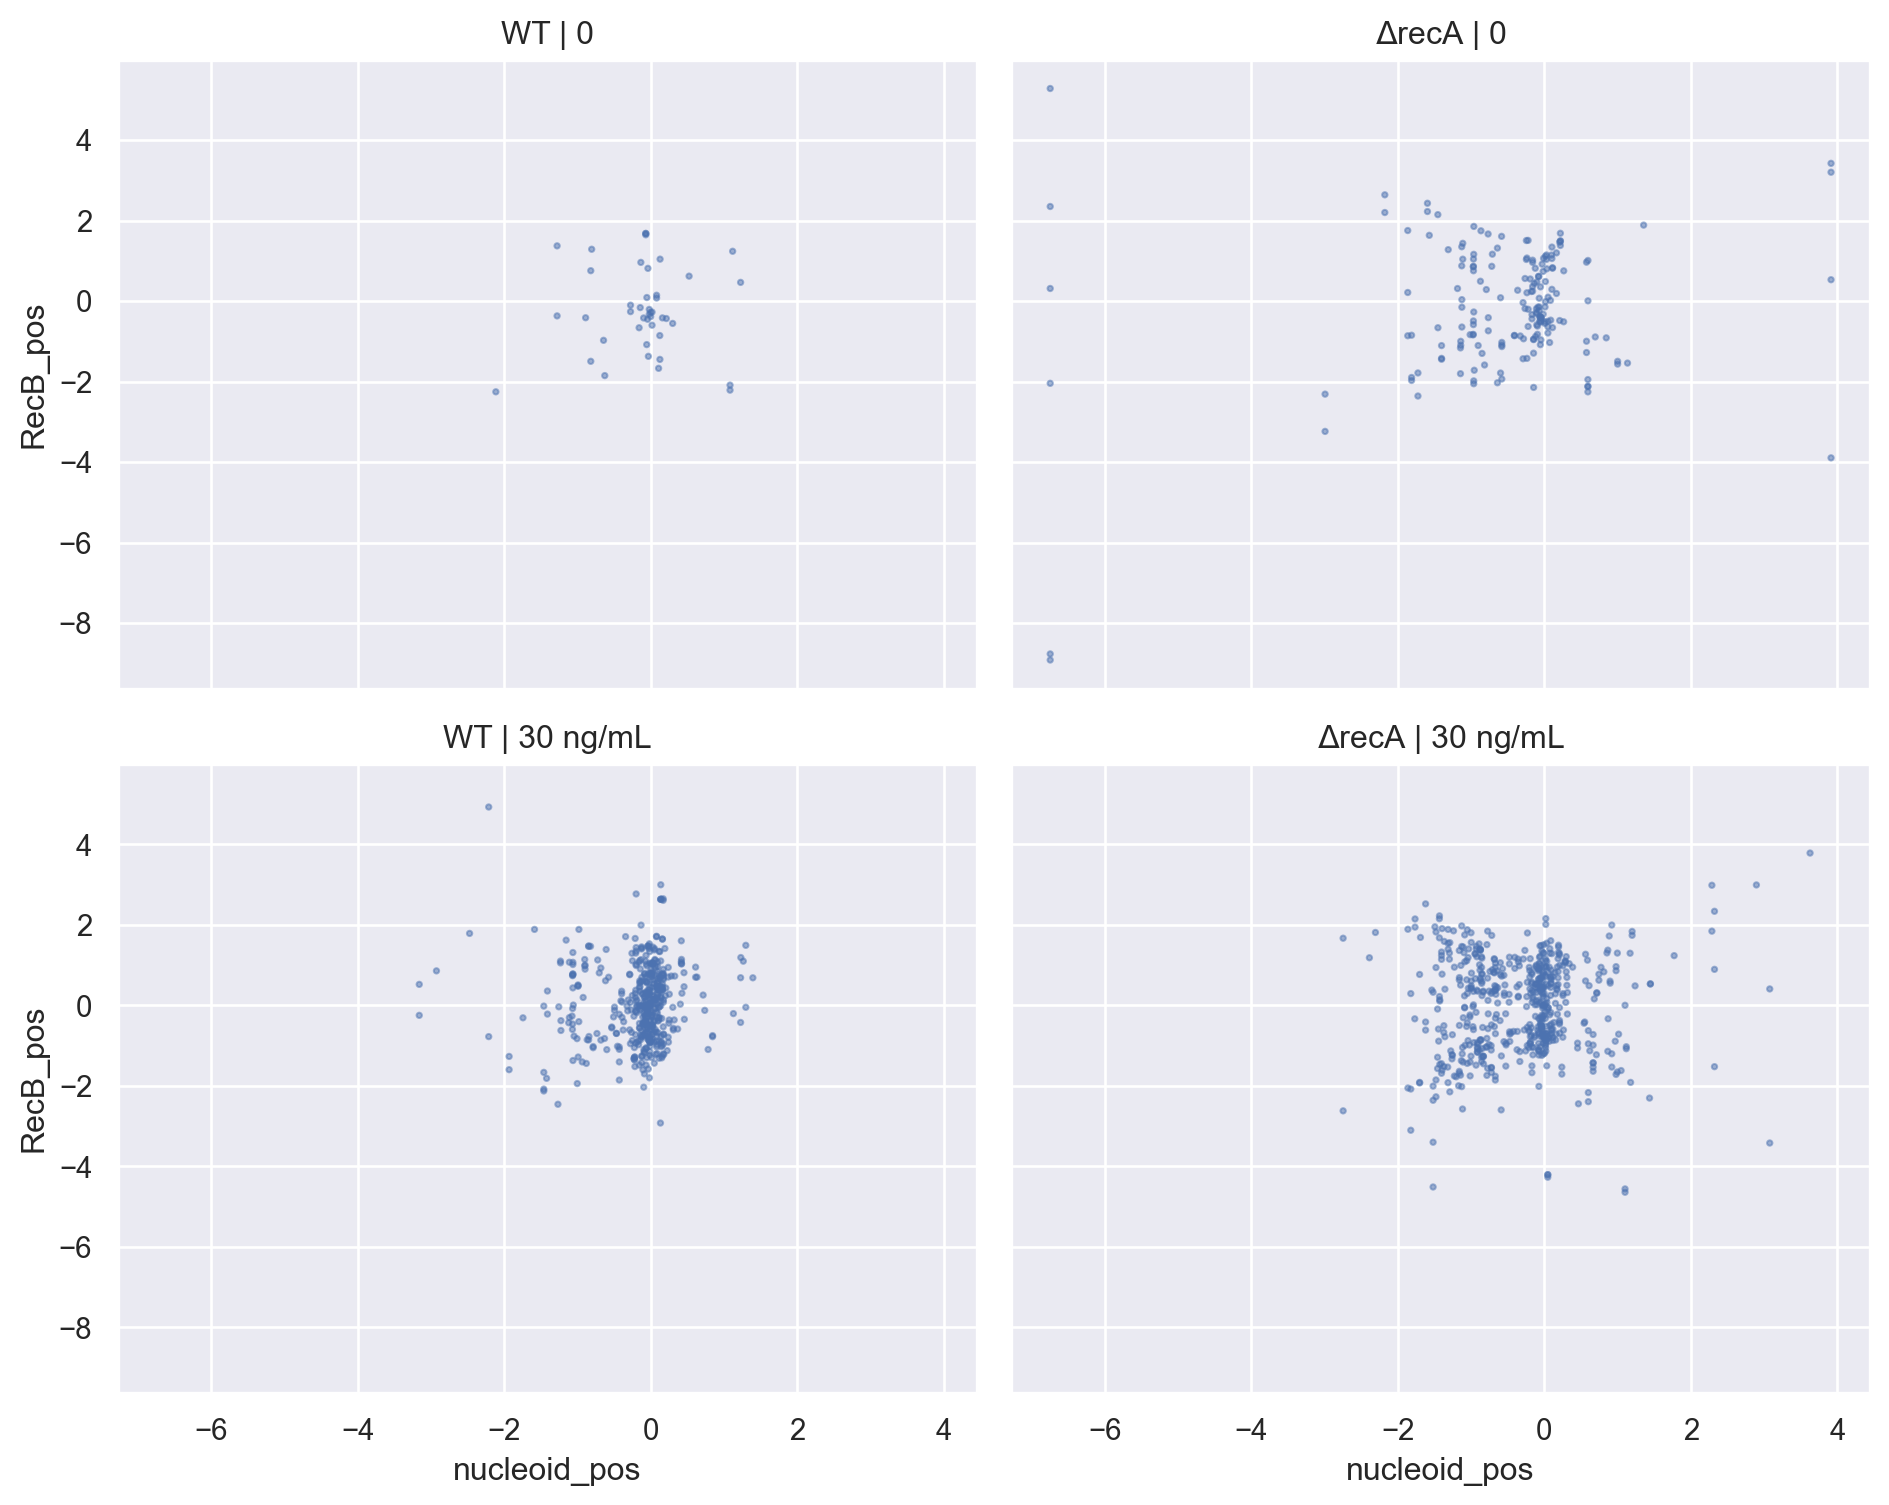

In [102]:
df = (data
      .add_from_child(object_name='Bacteria_large', col='centerLongCoord', child='Nucleoid', agg='first', rename='nucleoid_pos')
      .add_from_child(object_name='Bacteria_large', col=['centerLongCoord', 'TrackLength'], child='RecB_spots', agg='first', rename=['RecB_pos', 'TrackLength'])
      .Bacteria_large
      .query('TrackLength >= 5')
      )


(
    so.Plot(df, x='nucleoid_pos', y='RecB_pos')
    .layout(size=(10,8))
    .facet(row='Cipro', col='Strain')
    .add(so.Dots(marker='.', alpha=.5, fillalpha=.5))
)

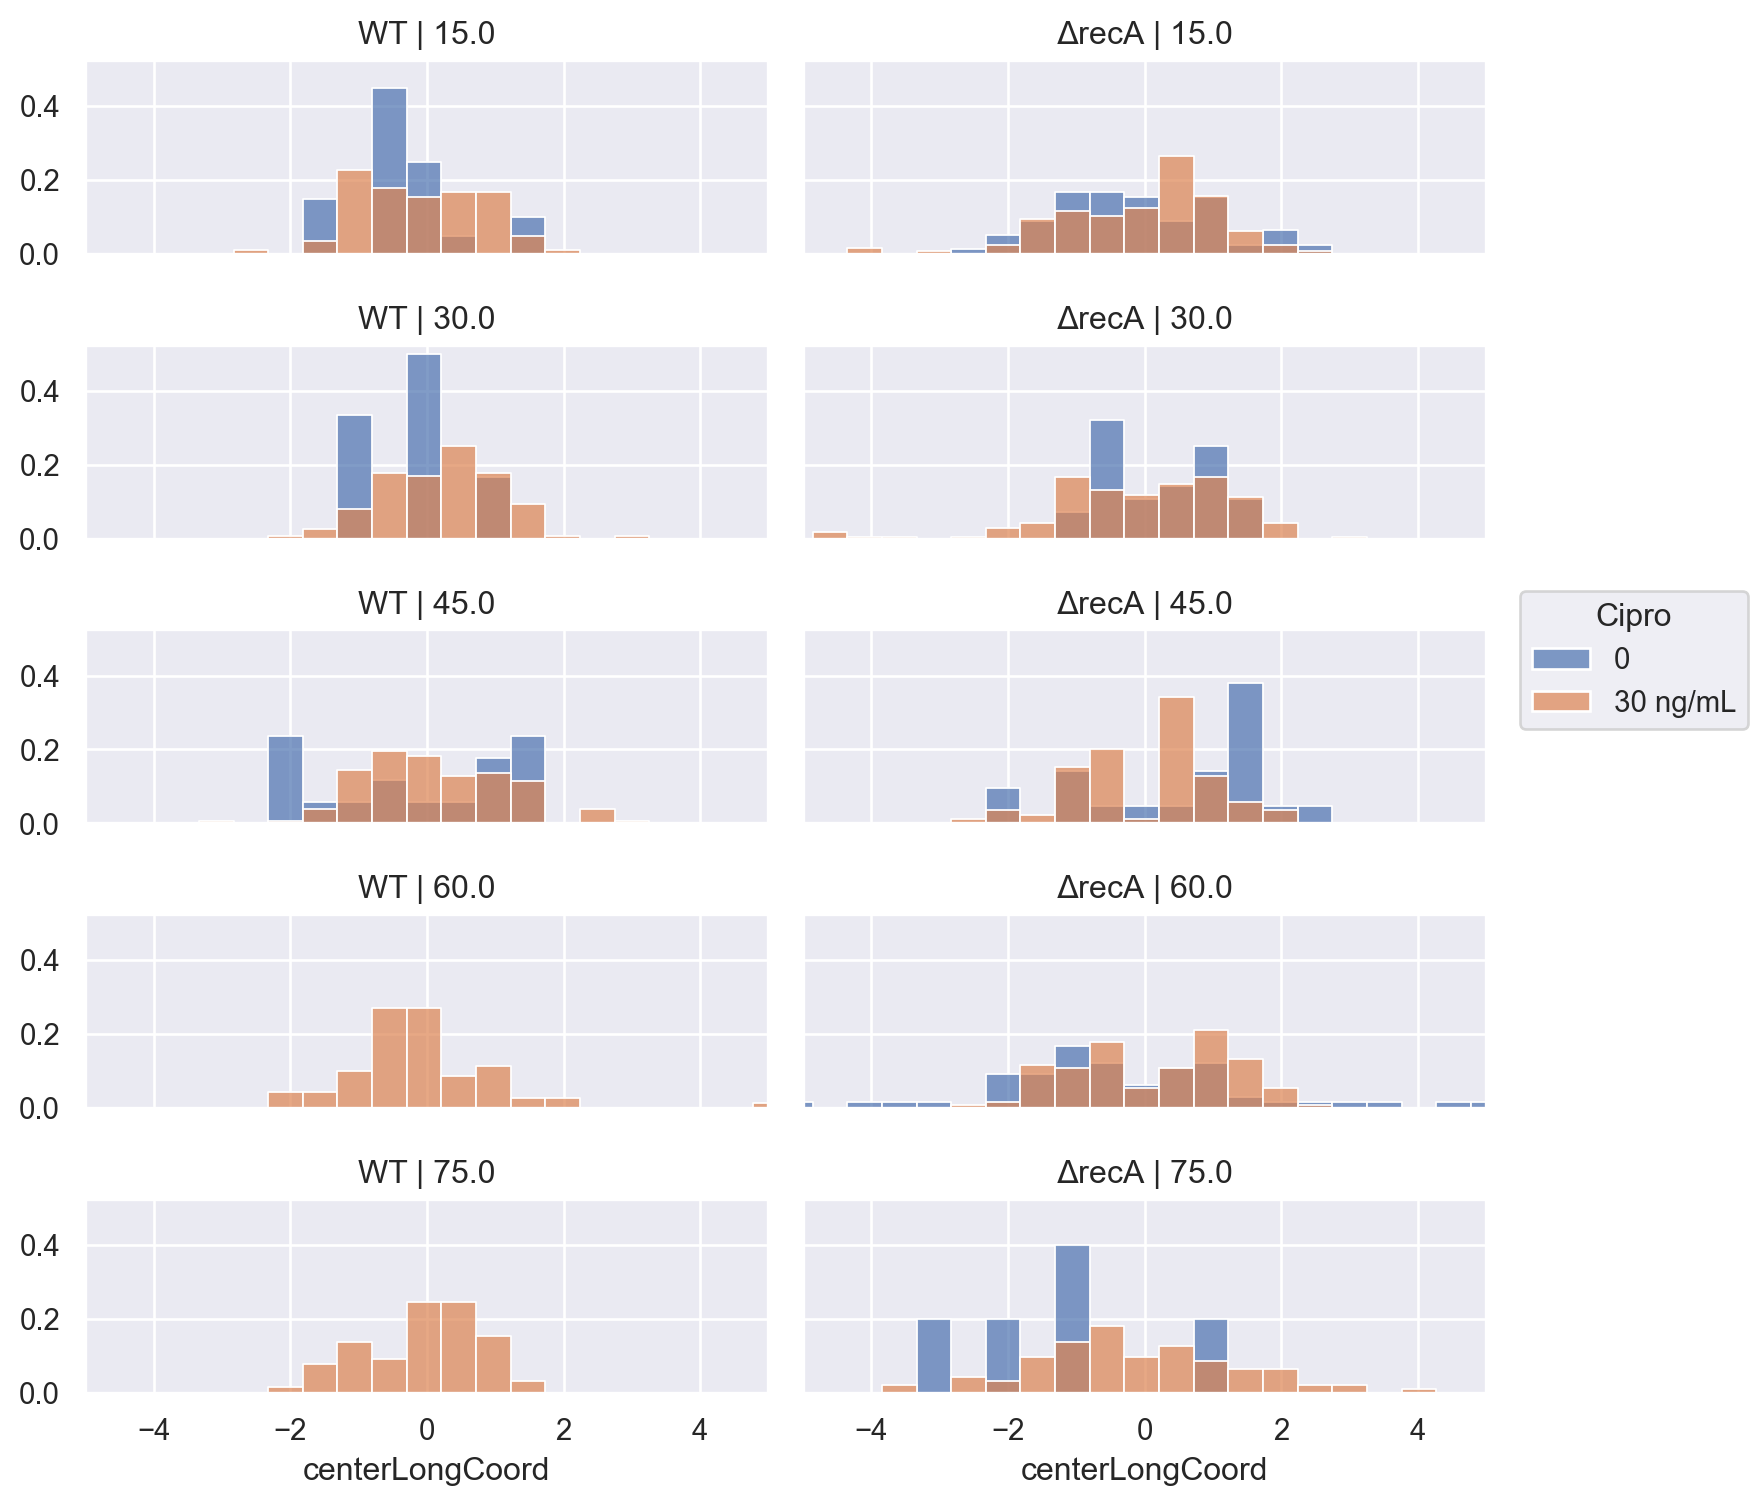

In [174]:
df = data.RecB_spots.query('TrackLength >= 5')

(
    so.Plot(df, x='centerLongCoord', color='Cipro')
    .facet(row='Time_min_bin', col='Strain')
    .layout(size=(8,8))
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.5, common_norm=False))
    .limit(x=(-5, 5))
)

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

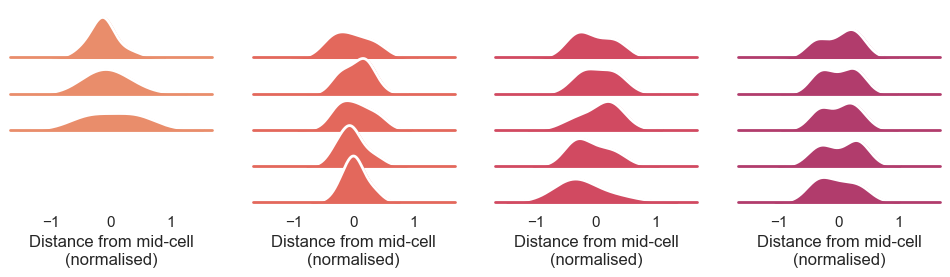

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=15, binlabels='left')
      .set_type(object_name='RecB_spots', type_dict={'Time_min_bin':'int'})
      .RecB_spots
      .query('TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue='Group', aspect=6, height=.5, palette=sns.color_palette('flare'))

# Draw the densities in a few steps
g.map(sns.kdeplot, "normLongCoord",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "normLongCoord", clip_on=False, color="w", lw=2, bw_adjust=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

# g.map(label, 'Time_min_bin')

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)